# BIOSIGNAL PROCESSING AND ANALYSIS PROJECT


In [37]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

print(X_train,y_train)
print(np.array(X_train).shape)

[[[-1.190e-01 -5.500e-02  6.400e-02 ... -2.600e-02 -3.900e-02 -7.900e-02]
  [-1.160e-01 -5.100e-02  6.500e-02 ... -3.100e-02 -3.400e-02 -7.400e-02]
  [-1.200e-01 -4.400e-02  7.600e-02 ... -2.800e-02 -2.900e-02 -6.900e-02]
  ...
  [ 6.900e-02  0.000e+00 -6.900e-02 ...  2.400e-02 -4.100e-02 -5.800e-02]
  [ 8.600e-02  4.000e-03 -8.100e-02 ...  2.420e-01 -4.600e-02 -9.800e-02]
  [ 2.200e-02 -3.100e-02 -5.400e-02 ...  1.430e-01 -3.500e-02 -1.200e-01]]

 [[ 4.000e-03  1.380e-01  1.340e-01 ...  1.920e-01  8.300e-02  8.800e-02]
  [-2.000e-02  1.160e-01  1.360e-01 ...  1.560e-01  5.700e-02  6.300e-02]
  [-5.300e-02  9.200e-02  1.450e-01 ...  1.070e-01  1.300e-02  2.200e-02]
  ...
  [ 1.210e-01  3.980e-01  2.770e-01 ... -1.065e+00 -4.920e-01 -1.560e-01]
  [-3.260e-01  5.700e-02  3.830e-01 ... -2.800e-01 -1.750e-01 -7.100e-02]
  [-3.480e-01 -5.600e-02  2.920e-01 ... -3.080e-01 -2.310e-01 -1.450e-01]]

 [[-2.900e-02 -7.900e-02 -4.900e-02 ... -1.030e-01 -7.600e-02 -6.600e-02]
  [-3.500e-02 -7.000e-

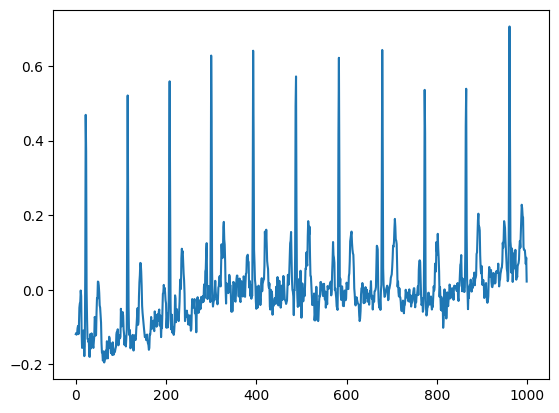

In [38]:
import matplotlib.pyplot as plt
# plot the first 2 signals
plt.plot(X_train[0, :, 0])
plt.show()

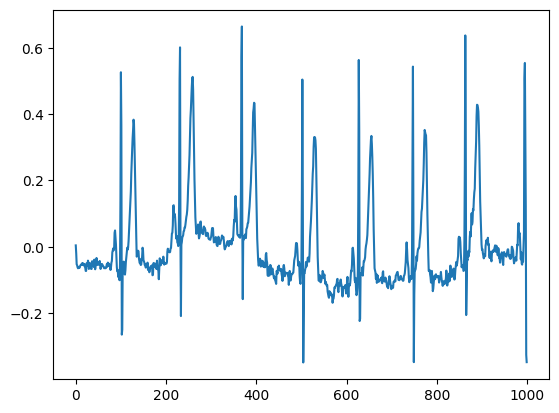

In [39]:
plt.plot(X_train[1, :, 0])
plt.show()

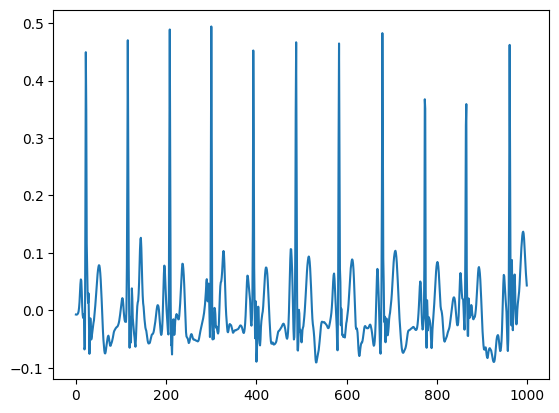

In [40]:
import pywt
import numpy as np
from scipy.signal import butter, filtfilt

def high_pass_filter(signal, cutoff=0.5, fs=100, order=5):
    # Normalizing the frequency
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def denoise_ecg(ecg_signal, wavelet='db6', level=4, fs=100):
    # First, apply high-pass filter to remove baseline wander
    ecg_signal = high_pass_filter(ecg_signal, cutoff=0.5, fs=fs)  # Adjust cutoff and fs as needed

    # Perform Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)

    # Threshold for denoising (universal threshold)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))

    # Apply threshold to detail coefficients
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]

    # Reconstruct the signal from denoised coefficients
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)

    return denoised_signal

ecg_signal = X_train[0, :, 0]
denoised_ecg = denoise_ecg(ecg_signal)

# Plotting the denoised signal
plt.plot(denoised_ecg)
plt.show()


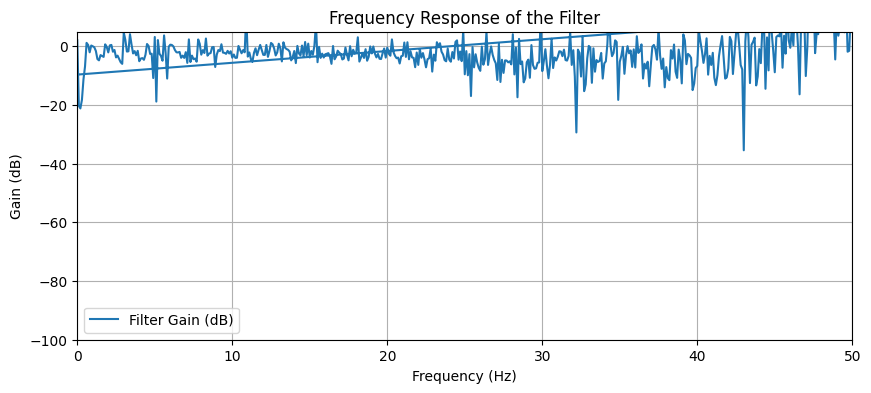

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_response(original_signal, denoised_signal, fs):
    """
    Plot the frequency response of a filter based on the original and denoised signals.

    Parameters:
    original_signal (array): The original unfiltered signal.
    denoised_signal (array): The signal after denoising or filtering.
    fs (int): Sampling frequency of the signals.
    """
    # Compute the Fast Fourier Transform (FFT) of the original and denoised signals
    orig_fft = np.fft.fft(original_signal)
    denoised_fft = np.fft.fft(denoised_signal)

    # Compute the frequency bins
    freq = np.fft.fftfreq(len(original_signal), d=1/fs)

    # Calculate the magnitude of the FFTs
    orig_mag = np.abs(orig_fft)
    denoised_mag = np.abs(denoised_fft)

    # Compute the gain of the filter as the ratio of the magnitudes
    gain = denoised_mag / orig_mag

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(freq, 20 * np.log10(gain), label='Filter Gain (dB)')
    plt.title('Frequency Response of the Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.xlim([0, fs/2])  # Limit to Nyquist frequency
    plt.ylim([-100, 5])  # Adjust this range based on your specific needs
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
# Ensure that original_signal and denoised_signal are numpy arrays with the same length
# fs should be the sampling frequency used when recording the signals

plot_frequency_response(ecg_signal, denoised_ecg, fs=100)

In [6]:
import numpy as np
import pywt
from scipy.signal import butter, filtfilt
from tqdm import tqdm

def high_pass_filter(signal, cutoff=0.5, fs=100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def denoise_ecg(ecg_signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

def process_ecg_dataset(dataset, fs=100):
    # dataset shape should be (samples, time, channels)
    num_samples, _, num_channels = dataset.shape
    denoised_dataset = np.empty_like(dataset)

    for i in tqdm(range(num_samples), desc='Denoising ECG Samples'):
        for j in range(num_channels):
            # Extract the signal for each channel
            signal = dataset[i, :, j]
            # Remove baseline wander
            filtered_signal = high_pass_filter(signal, cutoff=0.5, fs=fs)
            # Denoise the signal
            denoised_signal = denoise_ecg(filtered_signal)
            # Store the denoised signal
            denoised_dataset[i, :, j] = denoised_signal

    return denoised_dataset

ecg_data = X_train
denoised_data = process_ecg_dataset(ecg_data)
print(denoised_data.shape)


Denoising ECG Samples:  57%|███████████████████████████████████████████████████████████████▊                                               | 11265/19601 [01:00<00:43, 190.32it/s]/home/cs20b1057/miniconda3/envs/srav_misc/lib/python3.9/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
Denoising ECG Samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19601/19601 [01:44<00:00, 186.97it/s]

(19601, 1000, 12)


In [7]:
# denoising the test data as well
denoised_test_data = process_ecg_dataset(X_test)
print(denoised_test_data.shape)

Denoising ECG Samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2198/2198 [00:12<00:00, 182.14it/s]

(2198, 1000, 12)


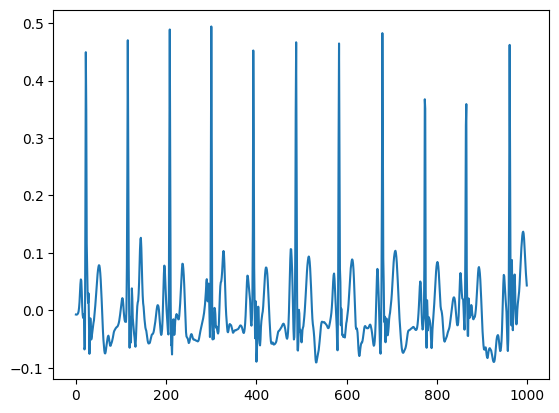

In [8]:
# plotting the first signal of the denoised data
plt.plot(denoised_data[0, :, 0])
plt.show()

In [9]:
# removing all the NaN values from the data and replacing them with 0
denoised_data = np.nan_to_num(denoised_data)
print(denoised_data.shape)

(19601, 1000, 12)


In [10]:
# putting the denoised data in x_train and x_test
X_train = denoised_data
X_test = denoised_test_data

In [11]:
# putting the first lead ecg data into a variable called 1st_lead_ecg_train
first_lead_ecg_train = X_train[:, :, 0]
print(first_lead_ecg_train.shape)

(19601, 1000)


In [12]:
# putting the remaining lead ecg data into a variable called remaining_lead_ecg_train
remaining_lead_ecg_train = X_train[:, :, 1:]
print(remaining_lead_ecg_train.shape)

(19601, 1000, 11)


In [13]:
# putting the first lead ecg data into a variable called 1st_lead_ecg_test
first_lead_ecg_test = X_test[:, :, 0]
print(first_lead_ecg_test.shape)

(2198, 1000)


In [14]:
# putting the remaining lead ecg data into a variable called remaining_lead_ecg_test
remaining_lead_ecg_test = X_test[:, :, 1:]
print(remaining_lead_ecg_test.shape)

(2198, 1000, 11)


Now with the data in the right shape, we can start building the model. We will start by building a model that uses only the first lead ECG data, that can predict the remaining lead ECG data. We will use a simple LSTM model for this task.

In [15]:
# Importing the necessary libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

2024-04-29 14:14:06.276237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:14:06.381399: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 14:14:06.939962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64::/home/cs20b1057/miniconda3/envs/

In [16]:
input_shape = (1000,1)

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
# tf.debugging.set_log_device_placement(True)
#
# try:
#   # Specify an invalid GPU device
#   with tf.device('GPU:1'):
#     # Building the model
#     model = Sequential()
#     model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
#     model.add(Dense(units = 11, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#     model.summary()
#     # Training the model
#     history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
# except RuntimeError as e:
#   print(e)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential()
model.add(LSTM(units=256, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))

model.add(Dense(units=11, activation='linear'))

2024-04-29 14:14:19.387734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:14:20.024525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78972 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:31:00.0, compute capability: 8.0


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 256)         264192    
                                                                 
 dropout (Dropout)           (None, 1000, 256)         0         
                                                                 
 dense (Dense)               (None, 1000, 128)         32896     
                                                                 
 lstm_1 (LSTM)               (None, 1000, 128)         131584    
                                                                 
 dropout_1 (Dropout)         (None, 1000, 128)         0         
                                                                 
 dense_1 (Dense)             (None, 1000, 64)          8256      
                                                                 
 lstm_2 (LSTM)               (None, 1000, 64)          3

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [22]:
# Training the model
history = model.fit(first_lead_ecg_train.reshape(-1,1000,1), remaining_lead_ecg_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

Epoch 1/100


2024-04-29 14:14:36.372593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-29 14:14:37.150553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


490/490 [==============================] - 70s 135ms/step - loss: 0.0269 - val_loss: 0.0254
Epoch 2/100
490/490 [==============================] - 65s 133ms/step - loss: 0.0235 - val_loss: 0.0247
Epoch 3/100
490/490 [==============================] - 64s 131ms/step - loss: 0.0228 - val_loss: 0.0242
Epoch 4/100
490/490 [==============================] - 61s 125ms/step - loss: 0.0224 - val_loss: 0.0236
Epoch 5/100
490/490 [==============================] - 66s 135ms/step - loss: 0.0220 - val_loss: 0.0231
Epoch 6/100
490/490 [==============================] - 65s 133ms/step - loss: 0.0218 - val_loss: 0.0232
Epoch 7/100
490/490 [==============================] - 65s 133ms/step - loss: 0.0215 - val_loss: 0.0228
Epoch 8/100
490/490 [==============================] - 65s 133ms/step - loss: 0.0213 - val_loss: 0.0225
Epoch 9/100
490/490 [==============================] - 65s 133ms/step - loss: 0.0211 - val_loss: 0.0224
Epoch 10/100
490/490 [==============================] - 66s 134ms/step - los

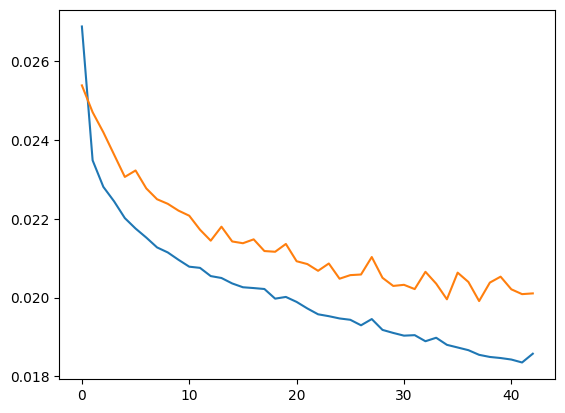

In [23]:
# plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
# # Making predictions
# with tf.device('GPU:1'):
#     predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
#     print(predictions.shape)

In [24]:
# Making predictions
predictions = model.predict(first_lead_ecg_test.reshape(-1,1000,1))
print(predictions.shape)

69/69 [==============================] - 5s 59ms/step
(2198, 1000, 11)


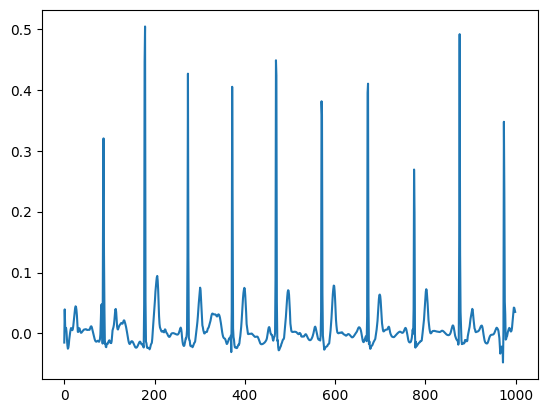

In [25]:
# plotting the prediction
plt.plot(predictions[0,:,1])
plt.show()

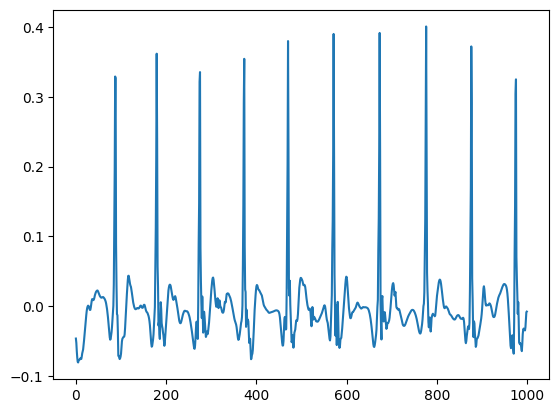

In [26]:
plt.plot(remaining_lead_ecg_test[0,:,1])
plt.show()

In [50]:
# evaluating the predictions using correlation and mean squared error

In [51]:
! pip install scikit-learn

/bin/bash: /home/cs20b1057/miniconda3/envs/srav_misc/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 2.4 MB/s eta 0:00:0000:01:00:01


In [27]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [28]:
# calculating the mean squared error
mse = mean_squared_error(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(mse)
# calculating rmse as the square root of mse
rmse = np.sqrt(mse)
print(rmse)

0.018841504929039025
0.13726436146734894


In [29]:
# calculating r2 score
from sklearn.metrics import r2_score
r2 = r2_score(remaining_lead_ecg_test.reshape(-1,1000), predictions.reshape(-1,1000))
print(r2)

0.5646936190260093


In [30]:
import numpy as np
from scipy.stats import pearsonr

# # Assuming you have your test data and labels
# X_test_reshaped = X_test.reshape(-1, 1000, 1)  # Reshape the test data if needed
# predictions = model.predict(X_test_reshaped)  # Get predictions for the test data

# Calculate Pearson correlation coefficient for each lead
correlations = []
for i in range(11):  # Assuming you have 11 leads
    actual = remaining_lead_ecg_test[:, :, i].flatten()  # Flatten the actual labels for the ith lead
    predicted = predictions[:, :, i].flatten()  # Flatten the predictions for the ith lead
    corr, _ = pearsonr(actual, predicted)  # Calculate Pearson correlation coefficient
    correlations.append(corr)

# Print the correlation coefficients for each lead
for i, corr in enumerate(correlations):
    print(f"Pearson correlation coefficient for lead {i+1}: {corr}")

Pearson correlation coefficient for lead 1: 0.698244969641329
Pearson correlation coefficient for lead 2: 0.6917309128301802
Pearson correlation coefficient for lead 3: 0.900583343109194
Pearson correlation coefficient for lead 4: 0.8986251808344583
Pearson correlation coefficient for lead 5: 0.5696280935339546
Pearson correlation coefficient for lead 6: 0.817343690194808
Pearson correlation coefficient for lead 7: 0.7487411872736829
Pearson correlation coefficient for lead 8: 0.6954321068031997
Pearson correlation coefficient for lead 9: 0.7305368415008877
Pearson correlation coefficient for lead 10: 0.7936022802866259
Pearson correlation coefficient for lead 11: 0.7944316505408323
